In [1]:
from interpretability_utilities import plot_frame_attributions, load_workspace_file, zero_crossing_rate

import pandas as pd
import pickle

import numpy as np
import librosa
import librosa.display
from scipy.stats import norm

import mlflow
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from captum.attr import Deconvolution, GuidedBackprop, NeuronDeconvolution, NeuronGuidedBackprop

## Settings and Utils

In [2]:
# Adjust according to your experiment
ref_fold = "8"
run_id = ""
tracking_server = ""
workspace_file = ""
dataset_dir = ""
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mlflow.set_tracking_uri(f"{tracking_server}:5000")
logged_model = mlflow.pytorch.load_model(f"runs:/{run_id}/models")
logged_model = logged_model.eval()


client = mlflow.MlflowClient()
run = client.get_run(run_id)
run_data = run.data
tags = run_data.tags

# Feature visualization
sr = int(tags["sample_rate"])
window_size = int(tags["window_size"])
hop_size = int(tags["hop_size"])
cur_window = 0

zcr_audios = {"avgZcr": [], "label": [], "frame": []}

In [3]:
inp_data, indexes, labels, _, lb_to_idx = load_workspace_file(workspace_file, ref_fold,
                                dataset_dir, device)

idx_to_label = {idx: label for label, idx in lb_to_idx.items()}
target = [idx for label, idx in lb_to_idx.items() if label.startswith("albilora")]

inp_data.requires_grad_()

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0555, -0.0193, -0.0721,  ..., -0.0414,  0.0826, -0.0263],
        [ 0.0400,  0.0262, -0.0200,  ...,  0.0005,  0.0032,  0.0033],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0022, -0.0013,  0.0012]],
       requires_grad=True)

In [4]:
def layer_attribution(model, layer, layer_name, inp_data, neuron, algorithm="deconv", verbose=False):
    channels = neuron[0]
    time_steps = neuron[1]
    mel_bins = neuron[2]
    
    tot = 0
    iterations = channels * time_steps * mel_bins
    
    if algorithm == "deconv":
        layer_deconv = NeuronDeconvolution(model, layer)
    elif algorithm == "guided":
        layer_deconv = NeuronGuidedBackprop(model, layer)
    else:
        raise ValueError(f"Incorrect algorithm {algorithm}. Expected 'deconv' or 'guided'")
        
    out_dict = {"input": [], "layer": [], "channel": [], "time_steps": [], "mel_bins": [], "layer_avg_attr": []}
    data_size = inp_data.size()[0]
    for channel in range(channels):
        for time_step in range(time_steps):
            for mel_bin in range(mel_bins):
                conv1_neuron_attr = layer_deconv.attribute(inp_data, (channel, time_step, mel_bin))
                out_dict["layer_avg_attr"].extend(torch.mean(conv1_neuron_attr, dim=1).cpu().detach().numpy().tolist())
                
                if device == 'cuda':
                    del conv1_neuron_attr
                    torch.cuda.empty_cache()
                    
                out_dict["input"].extend([i for i in range(data_size)])
                out_dict["layer"].extend([layer_name]*data_size)
                out_dict["channel"].extend([channel]*data_size)
                out_dict["time_steps"].extend([time_step]*data_size)
                out_dict["mel_bins"].extend([mel_bin]*data_size)
                if verbose:
                    tot += 1
                    print(f"Progress: {tot}/{iterations}-----------{100*tot/iterations:.2f}%", end="\r")
                                                
    return out_dict

In [5]:
# Compute ZCR to possible percussive audios
# https://github.com/tyiannak/pyAudioAnalysis
def zero_crossing_rate(frame):
    count = len(frame)
    count_zero = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    return np.float64(count_zero) / np.float64(count - 1.0)

In [6]:
rng = np.random.default_rng(135)

In [7]:
# Tentative to centralize as cubic root of 360 as 7.11
samples = 360 # Approximately
channels = rng.integers(64)
time_steps = rng.integers(np.floor(samples/channels))
mel_bins = int(np.floor(samples / (channels * time_steps)))
print(channels * time_steps * mel_bins, channels, time_steps, mel_bins)

360 30 6 2


## Zeiler and Fergus (2014)- Deconvolution

### Model attribution

In [11]:
deconv = Deconvolution(logged_model)

General attribution

In [ ]:
gen_attribution = deconv.attribute(inp_data, target=np.argmax(labels, axis=1))

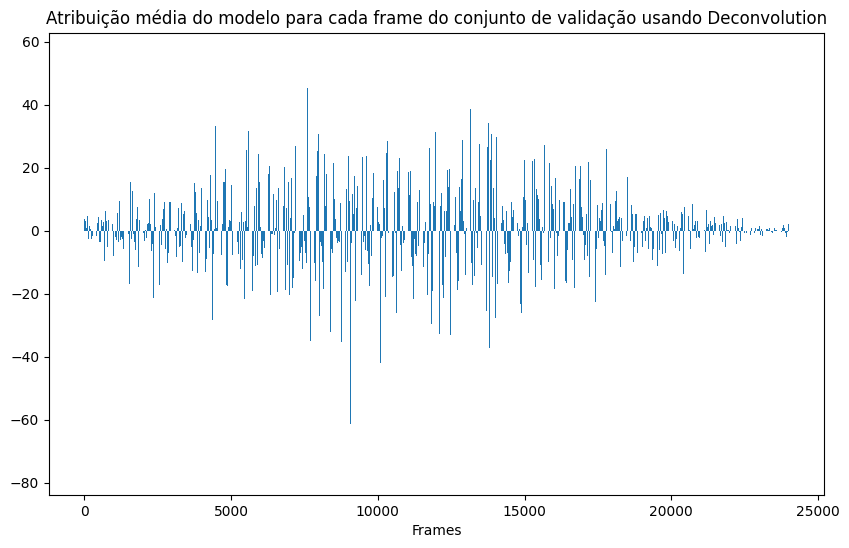

In [13]:
plot_frame_attributions(gen_attribution, title="Atribuição média do modelo para cada frame do conjunto de validação usando Deconvolution")

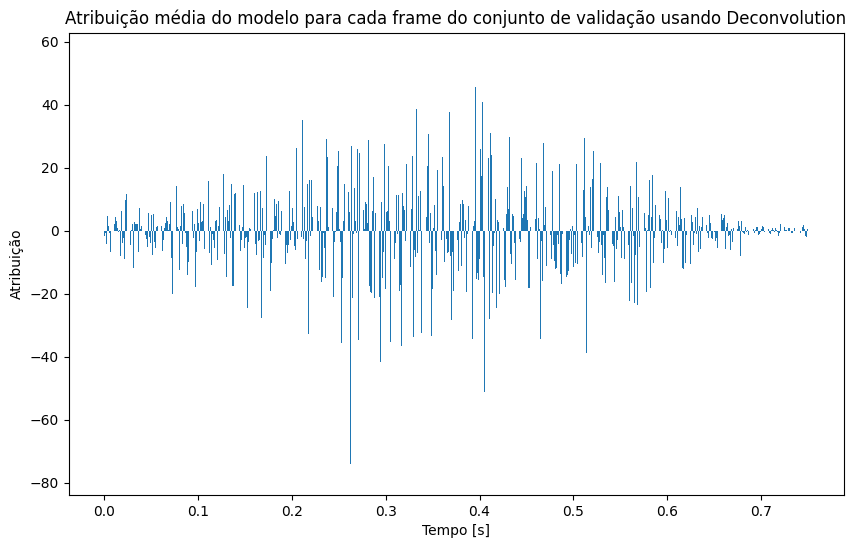

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(np.arange(gen_attribution.size()[1]), np.mean(gen_attribution.cpu().detach().numpy(), axis=0))

ax.set_xlabel("Tempo [s]")
ax.set_ylabel("Atribuição")

ax.set_xticks(np.arange(0, gen_attribution.size()[1], int(sr/10)))
ax.set_xticklabels(np.arange(0, 0.75, 0.10, dtype=np.float32))

ax.set_title("Atribuição média do modelo para cada frame do conjunto de validação usando Deconvolution")

fig.show()

There was a significant impact in attribution for the middle of the audio. Maybe the way I've selected the audios has influency for greather attributions between 0.25 seconds and 0.625 seconds (5000/24000 and 15000/24000)

### Neuron attribution

- Neuron's indices: (0..63, 0..37, 0..31) - (channels, time_steps or num_frames, mel_bins), i.e, Neuron's output dimension
- channels always doubling
- num_frames = 1+ceil(len_y / hop_length) if center is True
- else 1 + ceil(len_y - n_fft) / hop_length where len_y is the length of the audio

First Convolutional Block

In [15]:
neuron_deconv_conv1 = NeuronDeconvolution(logged_model, logged_model.base.conv_block1)

In [16]:
neuron_ca_attributions = neuron_deconv_conv1.attribute(inp_data, (0, 37, 31))

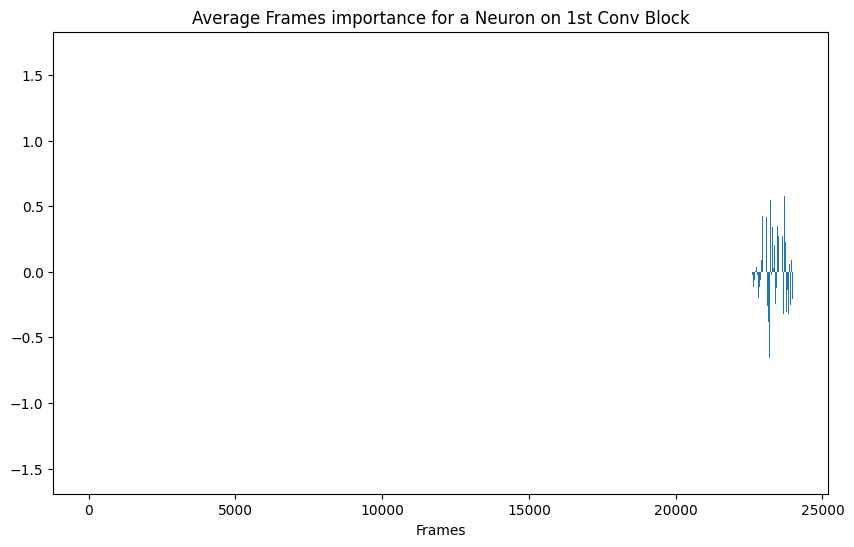

In [17]:
plot_frame_attributions(neuron_ca_attributions, title="Average Frames importance for a Neuron on 1st Conv Block")

Again for the same block

In [18]:
neuron_ca_attributions_2 = neuron_deconv_conv1.attribute(inp_data, (33, 15, 12))

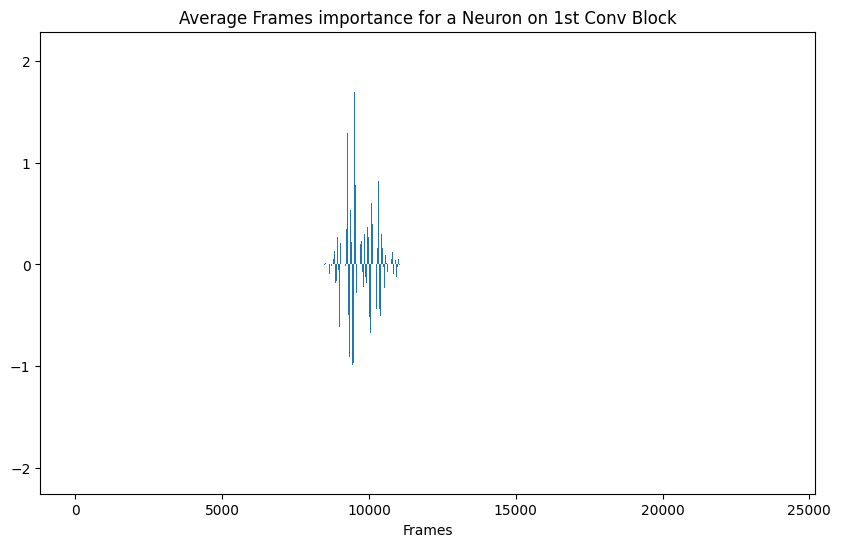

In [19]:
plot_frame_attributions(neuron_ca_attributions_2, title="Average Frames importance for a Neuron on 1st Conv Block")

### Layer attribution

It takes too much time running the algorithm for all 77824 neurons. I will define a bootrasp distribution from some neurons to speed up processing and minimize biases on analysis

#### First block

In [21]:
%%time
block_attr_block_1_deconv_meta = layer_attribution(
    logged_model,
    logged_model.base.conv_block1,
    "Conv 1 block",
    inp_data,
    (channels, time_steps, mel_bins), verbose=True
)

CPU times: user 2h 37min 45s, sys: 43min 43s, total: 3h 21min 29s
Wall time: 51min 28s


In [23]:
df = pd.DataFrame(block_attr_block_1_deconv_meta)
df.to_csv("data/block_attr_block_1_deconv_meta.csv", index=None)
uniques = df["input"].unique()

attr_mean_bootstrap = {"input": [], "attribution": []}
for i in range(10000):
    attr_mean_bootstrap["attribution"].extend(rng.choice(df["layer_avg_attr"].values, size=len(uniques)))
    

for i in range(10000):
    attr_mean_bootstrap["input"].extend([j for j in range(len(uniques))])

attr_mean_bootstrap = pd.DataFrame(attr_mean_bootstrap)
std_error = np.std(attr_mean_bootstrap["attribution"], ddof=1)
pop_std_error = std_error * np.sqrt(len(df))
print(std_error, pop_std_error)

7.246927614919247e-08 3.138513748666508e-05


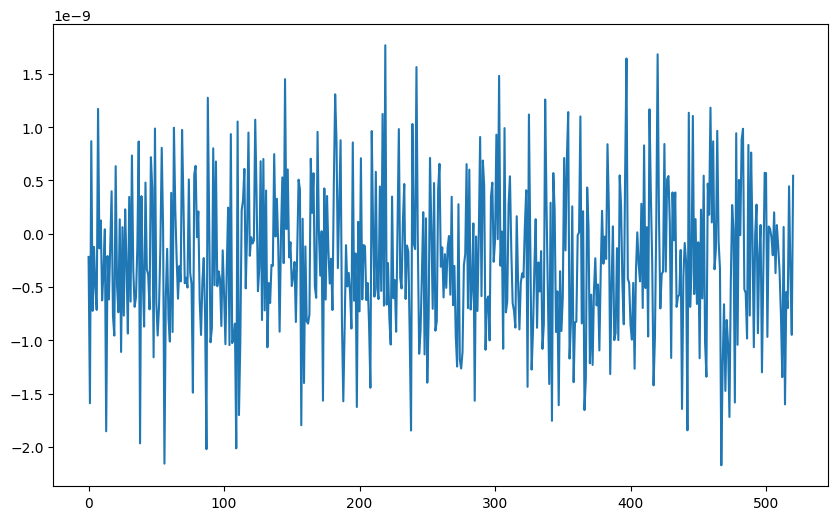

In [24]:
plt.figure(figsize=(10, 6))
input_attr = attr_mean_bootstrap.groupby("input")["attribution"].mean()
plt.plot(np.arange(len(uniques)), input_attr);

90% confidence interval

In [28]:
point_estimate = np.mean(attr_mean_bootstrap["attribution"])
lower = norm.ppf(0.05, loc=point_estimate, scale=std_error)
upper = norm.ppf(0.95, loc=point_estimate, scale=std_error)
print(lower, upper)

-1.1945909382174163e-07 1.1894360961135252e-07


In [32]:
attr_mean_bootstrap.to_csv("data/block_bootstrap_attr_block_1_deconv_meta.csv", index=None)

#### Second block

In [33]:
%%time
block_attr_block_2_deconv_meta = layer_attribution(
    logged_model,
    logged_model.base.conv_block2,
    "Conv 2 block",
    inp_data,
    (channels, time_steps, mel_bins), verbose=True
)

CPU times: user 2h 59min 19s, sys: 50min 53s, total: 3h 50min 13s
Wall time: 58min 50s


In [34]:
df = pd.DataFrame(block_attr_block_2_deconv_meta)
df.to_csv("data/block_attr_block_2_deconv_meta.csv", index=None)
uniques = df["input"].unique()

attr_mean_bootstrap = {"input": [], "attribution": []}
for i in range(10000):
    attr_mean_bootstrap["attribution"].extend(rng.choice(df["layer_avg_attr"].values, size=len(uniques)))
    

for i in range(10000):
    attr_mean_bootstrap["input"].extend([j for j in range(len(uniques))])

attr_mean_bootstrap = pd.DataFrame(attr_mean_bootstrap)
std_error = np.std(attr_mean_bootstrap["attribution"], ddof=1)
pop_std_error = std_error * np.sqrt(len(df))
print(std_error, pop_std_error)

6.186949077528502e-08 2.6794561466499685e-05


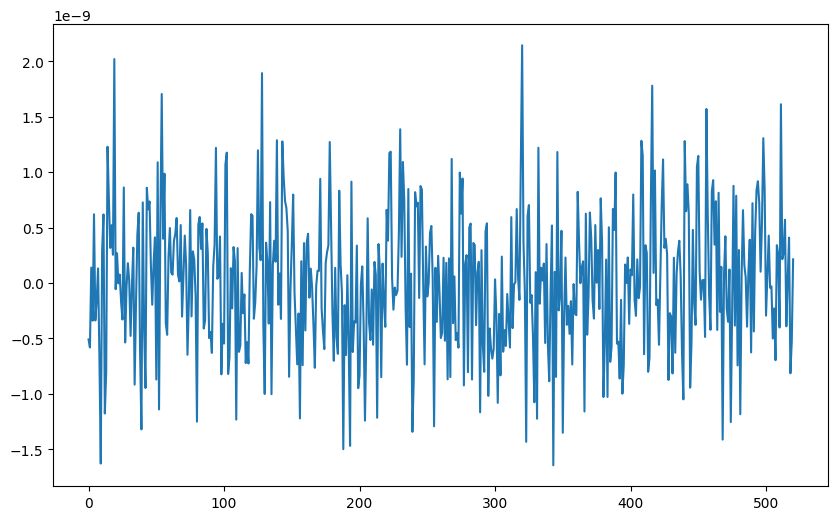

In [35]:
plt.figure(figsize=(10, 6))
input_attr = attr_mean_bootstrap.groupby("input")["attribution"].mean()
plt.plot(np.arange(len(uniques)), input_attr);

90% confidence interval

In [36]:
point_estimate = np.mean(attr_mean_bootstrap["attribution"])
lower = norm.ppf(0.05, loc=point_estimate, scale=std_error)
upper = norm.ppf(0.95, loc=point_estimate, scale=std_error)
print(lower, upper)

-1.0175708344409395e-07 1.0177542915464253e-07


In [37]:
attr_mean_bootstrap.to_csv("data/block_bootstrap_attr_block_2_deconv_meta.csv", index=None)

#### 5th block

In [38]:
time_steps_5th_layer = 2
mel_bins_5th_layer = 2
channels_5th_layer = 90

In [39]:
%%time
block_attr_block_5_deconv_meta = layer_attribution(
    logged_model,
    logged_model.base.conv_block5,
    "Conv 5 block",
    inp_data,
    (channels_5th_layer, time_steps_5th_layer, mel_bins_5th_layer),
    verbose=True
)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


CPU times: user 3h 45min 51s, sys: 55min 36s, total: 4h 41min 27s
Wall time: 1h 13min 28s


In [40]:
df = pd.DataFrame(block_attr_block_5_deconv_meta)
df.to_csv("data/block_attr_block_5_deconv_meta.csv", index=None)
uniques = df["input"].unique()

attr_mean_bootstrap = {"input": [], "attribution": []}
for i in range(10000):
    attr_mean_bootstrap["attribution"].extend(rng.choice(df["layer_avg_attr"].values, size=len(uniques)))
    

for i in range(10000):
    attr_mean_bootstrap["input"].extend([j for j in range(len(uniques))])

attr_mean_bootstrap = pd.DataFrame(attr_mean_bootstrap)
std_error = np.std(attr_mean_bootstrap["attribution"], ddof=1)
pop_std_error = std_error * np.sqrt(len(df))
print(std_error, pop_std_error)

5.466919286384991e-07 0.0002367624220206949


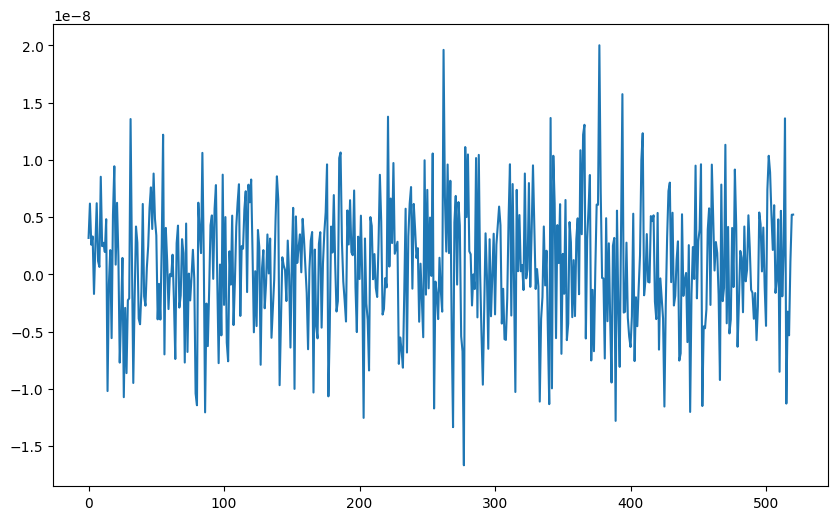

In [41]:
plt.figure(figsize=(10, 6))
input_attr = attr_mean_bootstrap.groupby("input")["attribution"].mean()
plt.plot(np.arange(len(uniques)), input_attr);

90% confidence interval

In [42]:
point_estimate = np.mean(attr_mean_bootstrap["attribution"])
lower = norm.ppf(0.05, loc=point_estimate, scale=std_error)
upper = norm.ppf(0.95, loc=point_estimate, scale=std_error)
print(lower, upper)

-8.985291856649491e-07 8.999272176273125e-07


In [43]:
attr_mean_bootstrap.to_csv("data/block_bootstrap_attr_block_5_deconv_meta.csv", index=None)

## Springebenberg et al. 2015- Guided Backpropagation

### Model attribution

In [44]:
guided_backprop = GuidedBackprop(logged_model)

In [ ]:
gen_attribution_guided = guided_backprop.attribute(inp_data, target=np.argmax(labels, axis=1))

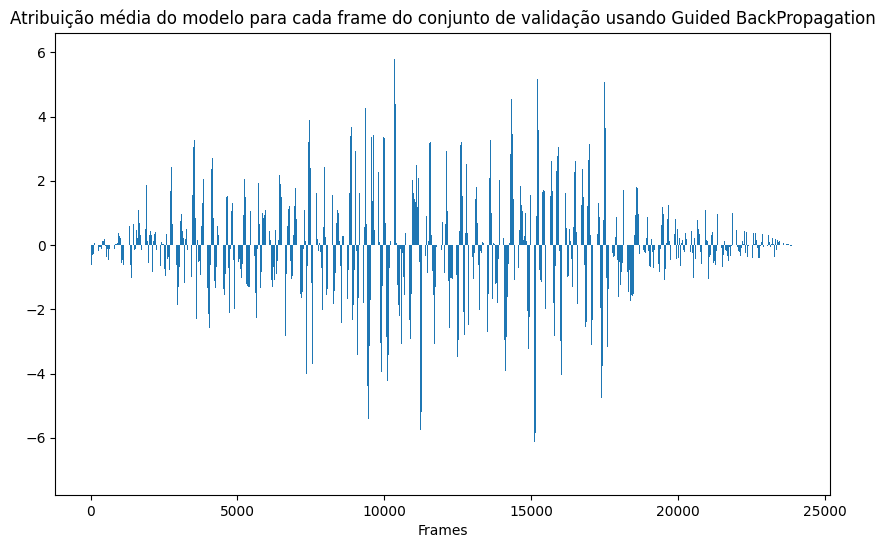

In [46]:
plot_frame_attributions(gen_attribution_guided, title="Atribuição média do modelo para cada frame do conjunto de validação usando Guided BackPropagation")

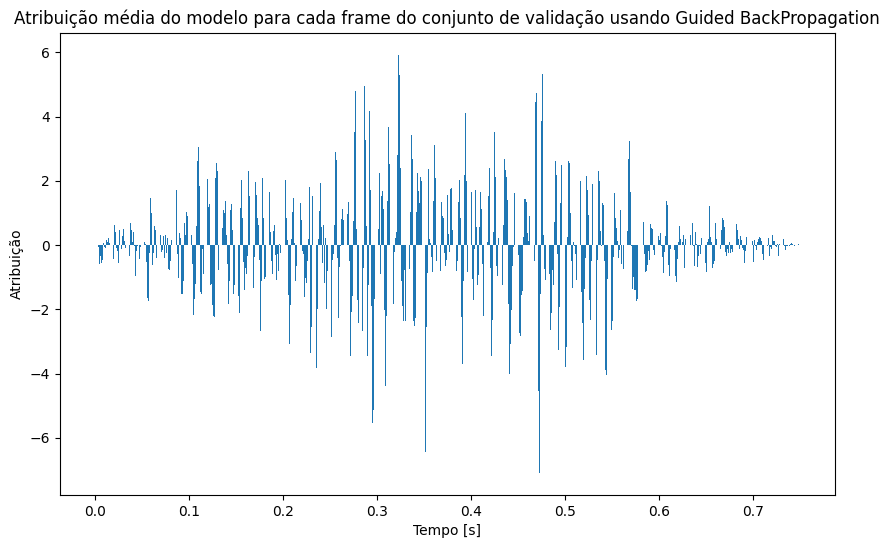

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(np.arange(gen_attribution_guided.size()[1]), np.mean(gen_attribution_guided.cpu().detach().numpy(), axis=0))

ax.set_xlabel("Tempo [s]")
ax.set_ylabel("Atribuição")

ax.set_xticks(np.arange(0, gen_attribution_guided.size()[1], int(sr/10)))
ax.set_xticklabels(np.arange(0, 0.75, 0.10, dtype=np.float32))

ax.set_title("Atribuição média do modelo para cada frame do conjunto de validação usando Guided BackPropagation")

fig.show()

### Layer attribution

#### First block

In [48]:
%%time
block_attr_block_1_guided_meta = layer_attribution(
    logged_model,
    logged_model.base.conv_block1,
    "Conv 1 block",
    inp_data,
    (channels, time_steps, mel_bins),
    "guided",
    verbose=True
)

CPU times: user 2h 41min 2s, sys: 40min 3s, total: 3h 21min 5s
Wall time: 52min 43s


In [49]:
df = pd.DataFrame(block_attr_block_1_guided_meta)
df.to_csv("data/block_attr_block_1_guided_meta.csv", index=None)
uniques = df["input"].unique()

attr_mean_bootstrap = {"input": [], "attribution": []}
for i in range(10000):
    attr_mean_bootstrap["attribution"].extend(rng.choice(df["layer_avg_attr"].values, size=len(uniques)))
    
for i in range(10000):
    attr_mean_bootstrap["input"].extend([j for j in range(len(uniques))])

attr_mean_bootstrap = pd.DataFrame(attr_mean_bootstrap)
std_error = np.std(attr_mean_bootstrap["attribution"], ddof=1)
pop_std_error = std_error * np.sqrt(len(df))
print(std_error, pop_std_error)

3.815868728315229e-08 1.6525839781079943e-05


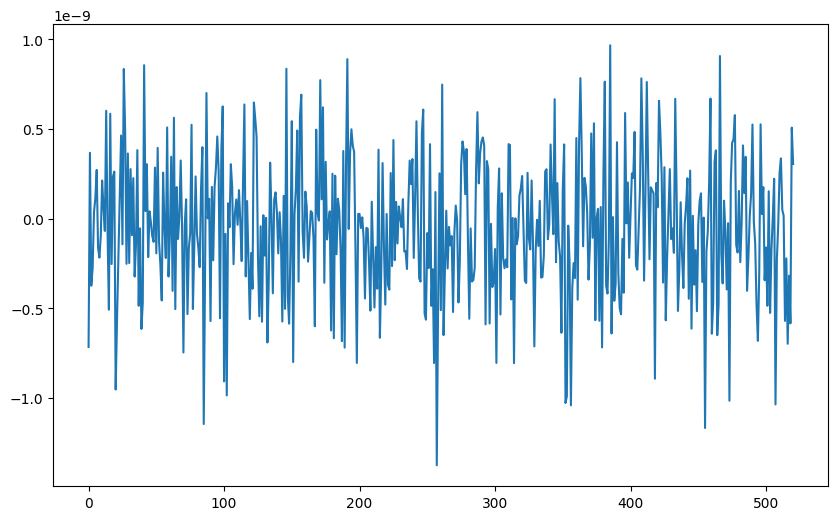

In [50]:
plt.figure(figsize=(10, 6))
input_attr = attr_mean_bootstrap.groupby("input")["attribution"].mean()
plt.plot(np.arange(len(uniques)), input_attr);

90% confidence interval

In [51]:
point_estimate = np.mean(attr_mean_bootstrap["attribution"])
lower = norm.ppf(0.05, loc=point_estimate, scale=std_error)
upper = norm.ppf(0.95, loc=point_estimate, scale=std_error)
print(lower, upper)

-6.28157432286428e-08 6.271516712615734e-08


In [52]:
attr_mean_bootstrap.to_csv("data/block_bootstrap_attr_block_1_guided_meta.csv", index=None)

#### Second block

In [53]:
%%time
block_attr_block_2_guided_meta = layer_attribution(
    logged_model,
    logged_model.base.conv_block2,
    "Conv 2 block",
    inp_data,
    (channels, time_steps, mel_bins),
    "guided",
    verbose=True
)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


CPU times: user 3h 1min 50s, sys: 44min 54s, total: 3h 46min 45s
Wall time: 59min 35s


In [54]:
df = pd.DataFrame(block_attr_block_2_guided_meta)
df.to_csv("data/block_attr_block_2_guided_meta.csv", index=None)
uniques = df["input"].unique()

attr_mean_bootstrap = {"input": [], "attribution": []}
for i in range(10000):
    attr_mean_bootstrap["attribution"].extend(rng.choice(df["layer_avg_attr"].values, size=len(uniques)))
    
for i in range(10000):
    attr_mean_bootstrap["input"].extend([j for j in range(len(uniques))])

attr_mean_bootstrap = pd.DataFrame(attr_mean_bootstrap)
std_error = np.std(attr_mean_bootstrap["attribution"], ddof=1)
pop_std_error = std_error * np.sqrt(len(df))
print(std_error, pop_std_error)

7.670528853111518e-08 3.32196781094824e-05


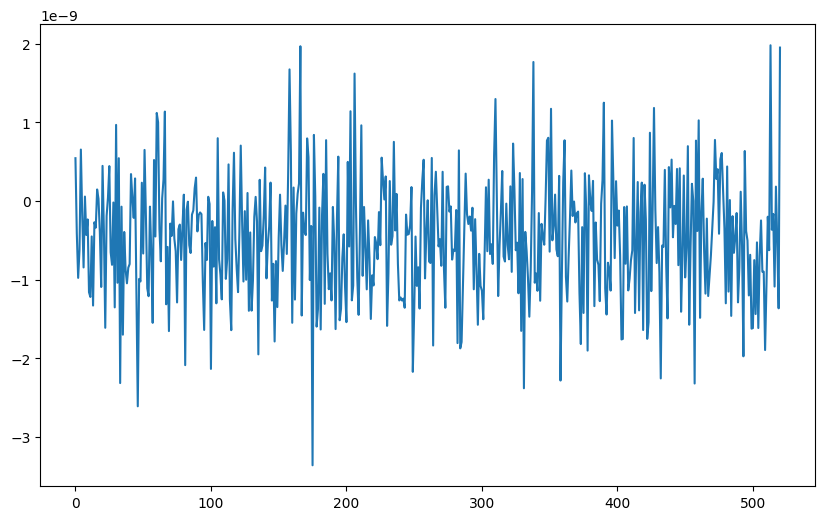

In [55]:
plt.figure(figsize=(10, 6))
input_attr = attr_mean_bootstrap.groupby("input")["attribution"].mean()
plt.plot(np.arange(len(uniques)), input_attr);

90% confidence interval

In [56]:
point_estimate = np.mean(attr_mean_bootstrap["attribution"])
lower = norm.ppf(0.05, loc=point_estimate, scale=std_error)
upper = norm.ppf(0.95, loc=point_estimate, scale=std_error)
print(lower, upper)

-1.266426015181671e-07 1.256953425753609e-07


In [57]:
attr_mean_bootstrap.to_csv("data/block_bootstrap_attr_block_2_guided_meta.csv", index=None)

#### 5th block

In [12]:
time_steps_5th_layer = 2
mel_bins_5th_layer = 2
channels_5th_layer = 90

In [13]:
%%time
block_attr_block_5_guided_meta = layer_attribution(
    logged_model,
    logged_model.base.conv_block5,
    "Conv 5 block",
    inp_data,
    (channels_5th_layer, time_steps_5th_layer, mel_bins_5th_layer),
    "guided",
    verbose=True
)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


CPU times: user 3h 45min 55s, sys: 56min 43s, total: 4h 42min 39s
Wall time: 1h 14min 5s


In [14]:
df = pd.DataFrame(block_attr_block_5_guided_meta)
df.to_csv("data/block_attr_block_5_guided_meta.csv", index=None)
uniques = df["input"].unique()

attr_mean_bootstrap = {"input": [], "attribution": []}
for i in range(10000):
    attr_mean_bootstrap["attribution"].extend(rng.choice(df["layer_avg_attr"].values, size=len(uniques)))
    
for i in range(10000):
    attr_mean_bootstrap["input"].extend([j for j in range(len(uniques))])

attr_mean_bootstrap = pd.DataFrame(attr_mean_bootstrap)
std_error = np.std(attr_mean_bootstrap["attribution"], ddof=1)
pop_std_error = std_error * np.sqrt(len(df))
print(std_error, pop_std_error)

9.783363792917724e-08 4.2369985466759133e-05


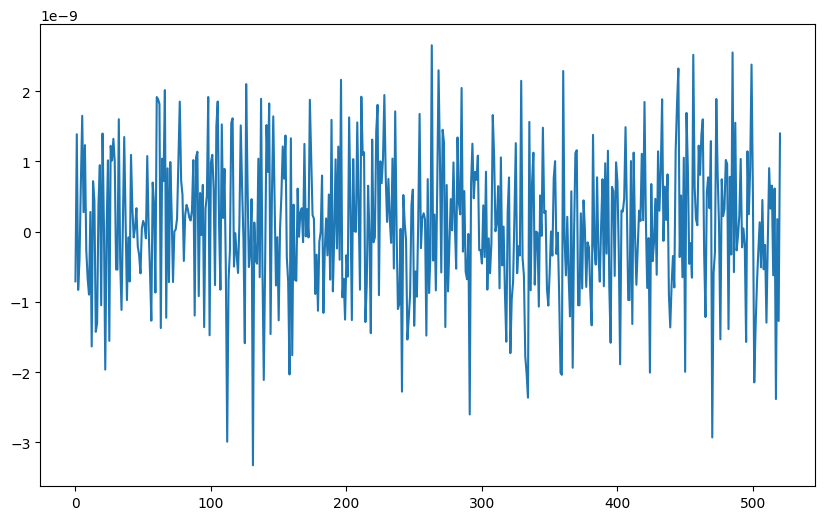

In [15]:
plt.figure(figsize=(10, 6))
input_attr = attr_mean_bootstrap.groupby("input")["attribution"].mean()
plt.plot(np.arange(len(uniques)), input_attr);

90% confidence interval

In [16]:
point_estimate = np.mean(attr_mean_bootstrap["attribution"])
lower = norm.ppf(0.05, loc=point_estimate, scale=std_error)
upper = norm.ppf(0.95, loc=point_estimate, scale=std_error)
print(lower, upper)

-1.6083004888617432e-07 1.6101397948515436e-07


In [17]:
attr_mean_bootstrap.to_csv("data/block_bootstrap_attr_block_5_guided_meta.csv", index=None)

## Feature Visualizations

In [8]:
deconv_1th_block = pd.read_csv("data/block_bootstrap_attr_block_1_deconv_meta.csv")
deconv_2th_block = pd.read_csv("data/block_bootstrap_attr_block_2_deconv_meta.csv")
deconv_5th_block = pd.read_csv("data/block_bootstrap_attr_block_5_deconv_meta.csv")

guided_1th_block = pd.read_csv("data/block_bootstrap_attr_block_1_guided_meta.csv")
guided_2th_block = pd.read_csv("data/block_bootstrap_attr_block_2_guided_meta.csv")
guided_5th_block = pd.read_csv("data/block_bootstrap_attr_block_5_guided_meta.csv")


In [9]:
largest_attr_1th_block_deconv = deconv_1th_block.groupby("input")["attribution"]\
    .sum().nlargest(3)

largest_attr_2th_block_deconv = deconv_2th_block.groupby("input")["attribution"]\
    .sum().nlargest(3)

# largest mean scale (1e-8)
largest_attr_5th_block_deconv = deconv_5th_block.groupby("input")["attribution"]\
    .sum().nlargest(4)

print(largest_attr_1th_block_deconv, largest_attr_2th_block_deconv, largest_attr_5th_block_deconv)

input
219    0.000018
420    0.000017
397    0.000016
Name: attribution, dtype: float64 input
320    0.000021
19     0.000020
128    0.000019
Name: attribution, dtype: float64 input
377    0.000200
262    0.000196
394    0.000157
221    0.000138
Name: attribution, dtype: float64


In [10]:
largest_attr_1th_block_guided = guided_1th_block.groupby("input")["attribution"]\
    .sum().nlargest(3)

largest_attr_2th_block_guided = guided_2th_block.groupby("input")["attribution"]\
    .sum().nlargest(3)

# greatest number of impactul attributions
largest_attr_5th_block_guided = guided_5th_block.groupby("input")["attribution"]\
    .sum().nlargest(4)

print(largest_attr_1th_block_guided, largest_attr_2th_block_guided, largest_attr_5th_block_guided)

input
385    0.000010
466    0.000009
191    0.000009
Name: attribution, dtype: float64 input
513    0.000020
166    0.000020
520    0.000019
Name: attribution, dtype: float64 input
263    0.000027
485    0.000025
456    0.000025
499    0.000024
Name: attribution, dtype: float64


In [11]:
unique_inputs = largest_attr_1th_block_deconv.index.union(
    largest_attr_2th_block_deconv.index
    ).union(
        largest_attr_5th_block_deconv.index
        ).union(
            largest_attr_1th_block_guided.index
        ).union(
            largest_attr_2th_block_guided.index
        ).union(
            largest_attr_5th_block_guided.index
        )

unique_inputs, len(unique_inputs)

(Int64Index([ 19, 128, 166, 191, 219, 221, 262, 263, 320, 377, 385, 394, 397,
             420, 456, 466, 485, 499, 513, 520],
            dtype='int64', name='input'),
 20)

Iterate over each audio considering the parameters for spectrogram generation

In [12]:
start = 0
num_frame = 1
num_audios = len(inp_data)

while cur_window + window_size - 1 < inp_data.shape[1]:

    for i in range(num_audios):
        frame = inp_data[i][cur_window:cur_window+window_size]

        frame_zcr = zero_crossing_rate(frame.cpu().detach().numpy())
        zcr_audios["avgZcr"].append(np.mean(frame_zcr))
        zcr_audios["label"].append(idx_to_label[np.argmax(labels.cpu().detach().numpy())])
        zcr_audios["frame"].append(num_frame)

    num_frame += 1
    cur_window += hop_size

In [13]:
zcr_audios = pd.DataFrame(zcr_audios)
zcr_audios

,avgZcr,label,frame
0,0.000000,FOR_Testing_Dry_Season,1
1,0.000000,FOR_Testing_Dry_Season,1
2,0.000000,FOR_Testing_Dry_Season,1
3,0.000000,FOR_Testing_Dry_Season,1
4,0.000000,FOR_Testing_Dry_Season,1
...,...,...,...
37507,0.543500,FOR_Testing_Dry_Season,72
37508,0.393939,FOR_Testing_Dry_Season,72
37509,0.589443,FOR_Testing_Dry_Season,72
37510,0.179863,FOR_Testing_Dry_Season,72


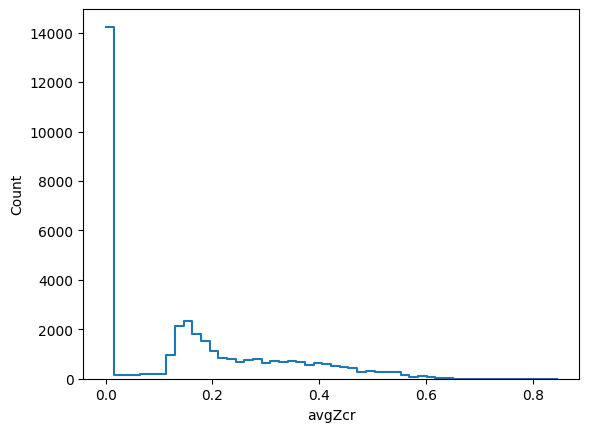

In [14]:
_, ax = plt.subplots()
sns.histplot(x="avgZcr", data=zcr_audios, element="step", fill=False, ax=ax);

In [15]:
first_18_frames_zcr_audios = zcr_audios[zcr_audios["frame"] <= 18]
frames_18_36_zcr_audios = zcr_audios[(zcr_audios["frame"] > 18) & (zcr_audios["frame"] <= 36)]
frames_36_54_zcr_audios = zcr_audios[(zcr_audios["frame"] > 36) & (zcr_audios["frame"] <= 54)]
frames_54_above_zcr_audios = zcr_audios[zcr_audios["frame"] > 54]

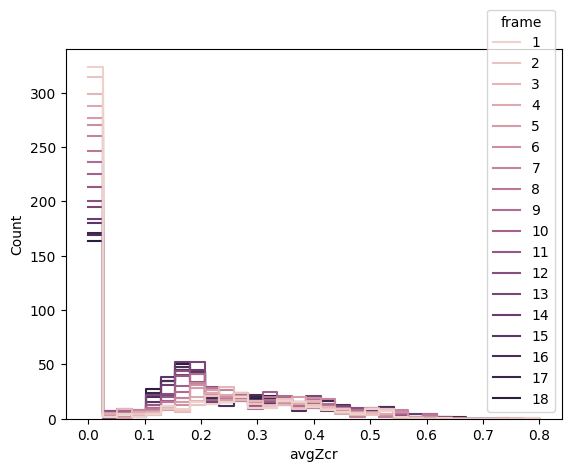

In [16]:
_, ax = plt.subplots()
sns.histplot(x="avgZcr", data=first_18_frames_zcr_audios, hue="frame", element="step", fill=False, ax=ax);

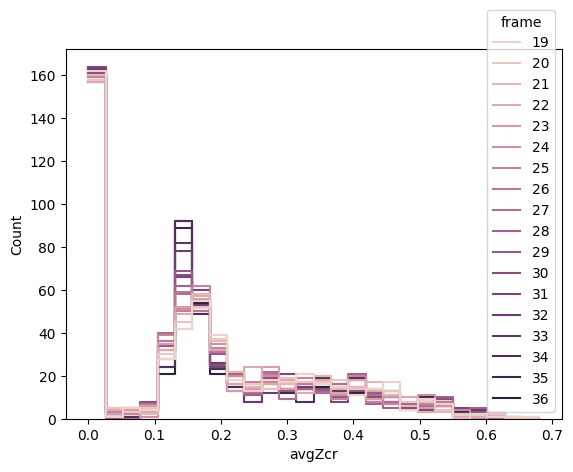

In [17]:
_, ax = plt.subplots()
sns.histplot(x="avgZcr", data=frames_18_36_zcr_audios, hue="frame", element="step", fill=False, ax=ax);

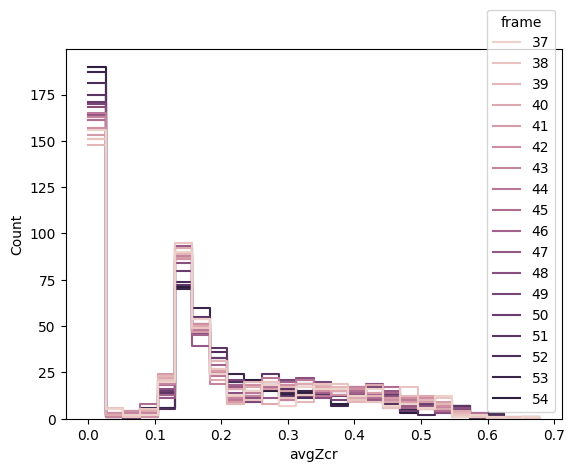

In [18]:
_, ax = plt.subplots()
sns.histplot(x="avgZcr", data=frames_36_54_zcr_audios, hue="frame", element="step", fill=False, ax=ax);

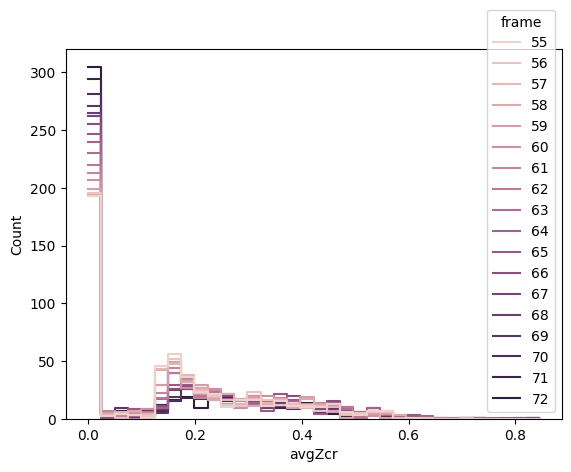

In [19]:
_, ax = plt.subplots()
sns.histplot(x="avgZcr", data=frames_54_above_zcr_audios, hue="frame", element="step", fill=False, ax=ax);

Check spectrograms with largest attribution

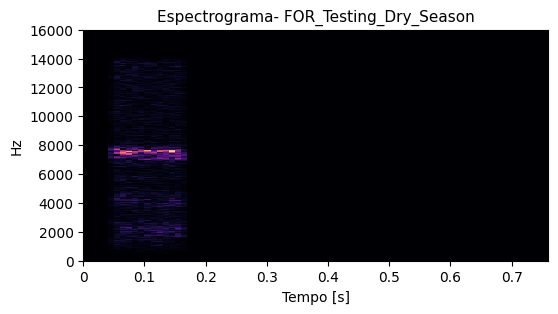

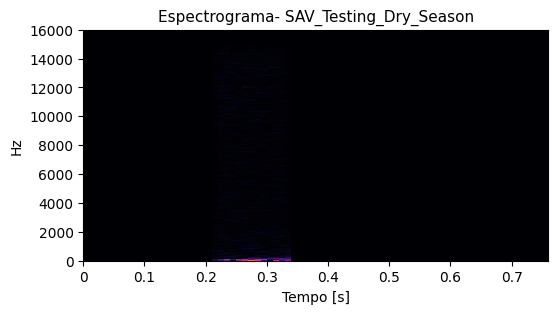

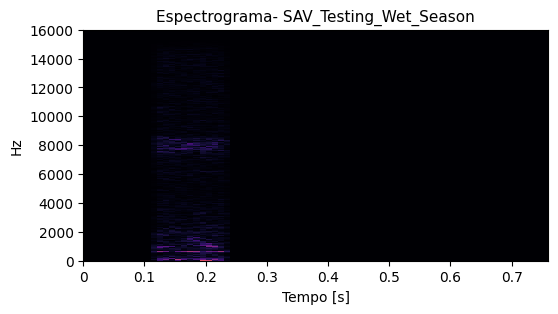

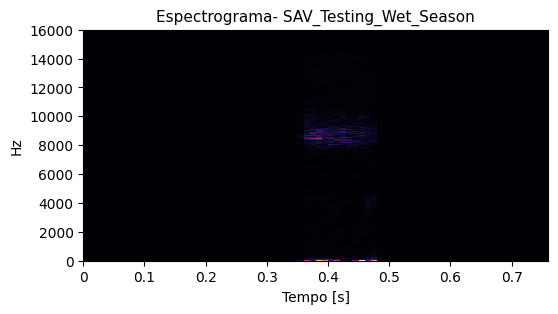

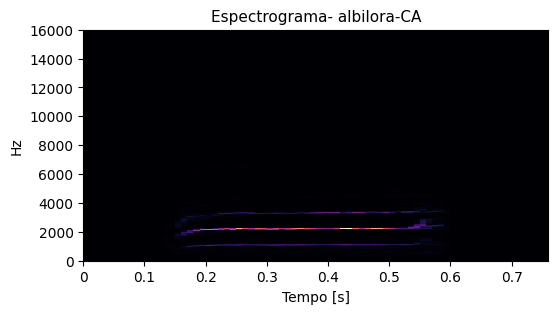

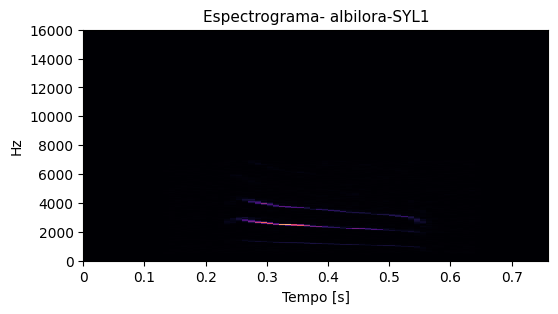

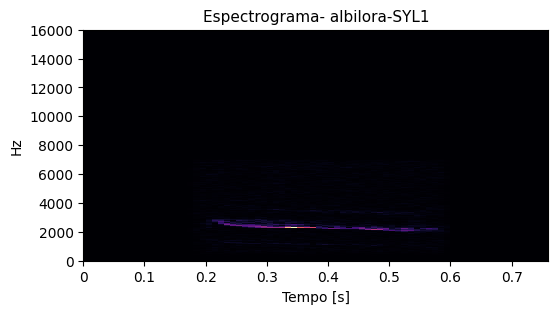

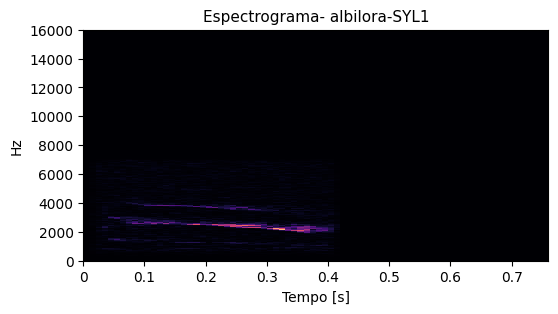

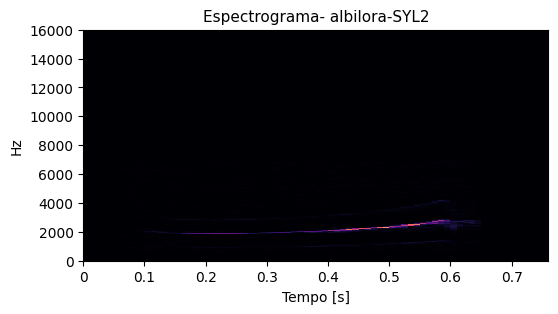

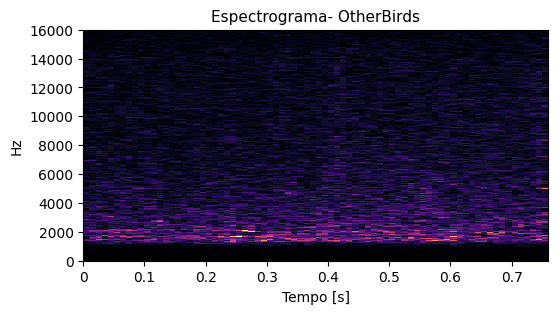

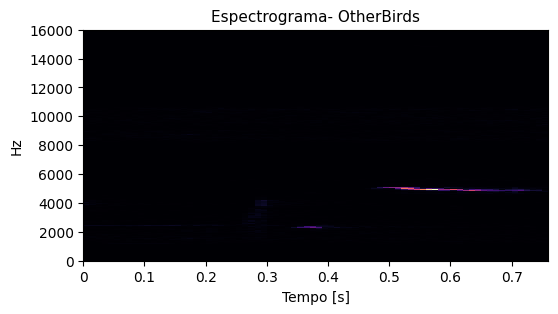

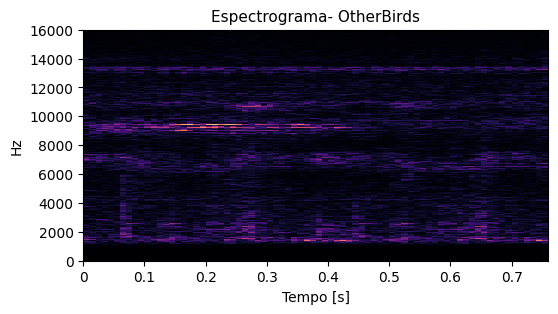

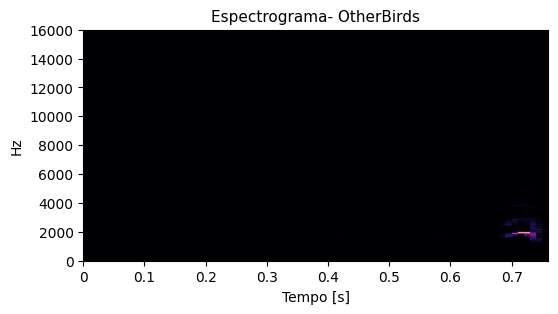

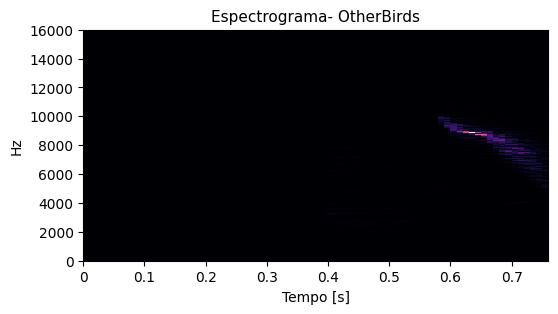

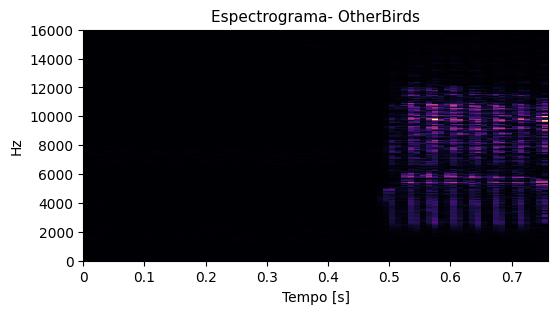

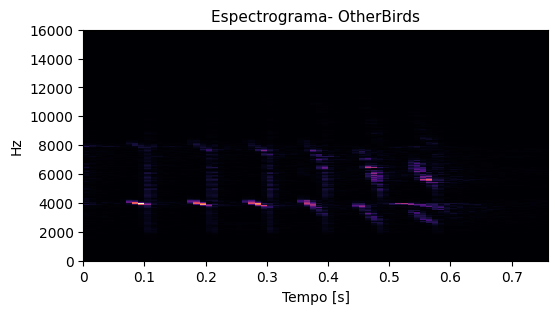

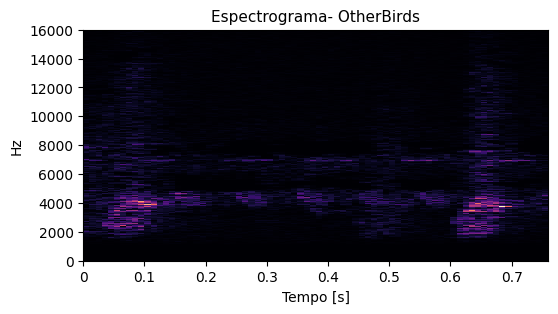

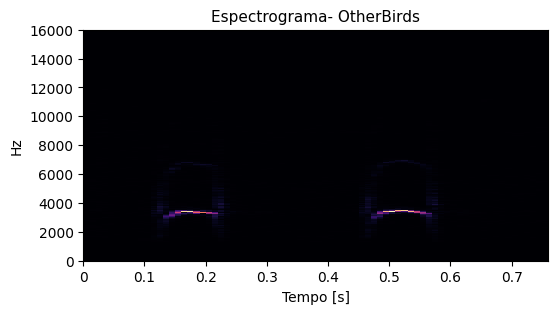

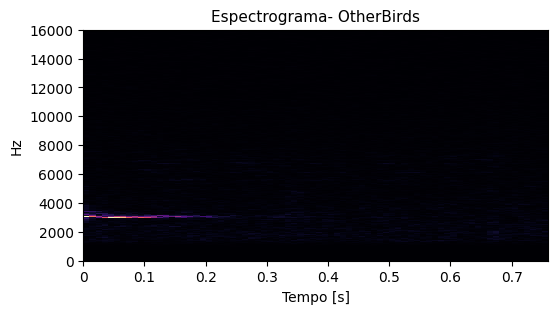

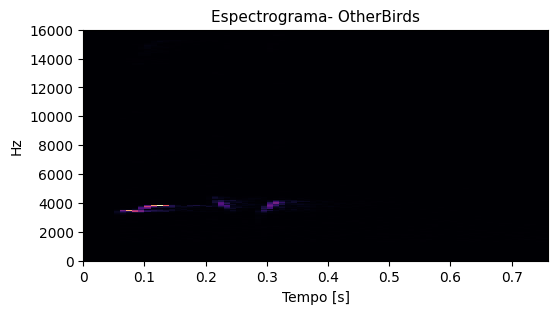

In [20]:
axes = []

for i, audio_ind in enumerate(unique_inputs):
    _, axis = plt.subplots(figsize=(6, 3))
    axes.append(axis)

    librosa.display.specshow(np.abs(
        librosa.stft(inp_data[audio_ind].cpu().detach().numpy(),
            n_fft=window_size, win_length=window_size, hop_length=hop_size, center=True)
        ),
        sr=sr, x_axis="time", y_axis="linear", hop_length=hop_size,
        fmin=int(tags["fmin"]), fmax=int(tags["fmax"]), ax=axes[i]
    )
    label = idx_to_label[np.argmax(labels[audio_ind].cpu().detach().numpy())]

    axes[i].set_title(f"Espectrograma- {'OtherBirds' if label == 'others' else label}",
                    {'fontsize': 11})

    axes[i].set_xlabel("Tempo [s]")
    
plt.show()